In [ ]:
!pip install tensorflow keras numpy pillow h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.data

mkdir: cannot create directory ‘/root/.data’: File exists


In [ ]:
!unzip drive/MyDrive/stan-para-dataset.zip -d ./data

Archive:  drive/MyDrive/stan-para-dataset.zip
replace ./data/stanford_df_rectified.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
from glob import glob
import pathlib
import csv
import re
from tqdm.notebook import tqdm
from PIL import Image
import pickle

import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional, Concatenate, RepeatVector, Activation, Dot
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences , plot_model
from keras.utils import to_categorical
from keras.models import load_model

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import single_meteor_score

In [ ]:
def preprocess_text(text):
    # caption cleaning
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9\n\.]', ' ', text)
    # delete additional spaces
    text = text.replace('\s+', ' ')
    text = 'startseq ' + " ".join([word for word in text.split() if len(word)>1]) + ' endseq'
    return text

# Preprocess the images
def preprocess_images(image_paths):
    # Load the image using Pillow
    def load_image(path):
        img = Image.open(path)
        img = img.convert('RGB')
        img = img.resize((299, 299))  # Xception model input size
        img = np.array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return img

    images = []
    for path in image_paths:
        images.append(load_image(path))
    images = np.vstack(images)
    return images

# Create a tokenizer for the captions
def create_tokenizer(captions, num_words=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<unk>", filters=string.punctuation)
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Create a vocabulary of words in the captions
def create_vocabulary(captions):
    vocab = set()
    for caption in captions:
        tokens = caption.split()
        vocab.update(tokens)
    return sorted(list(vocab))

# Create input-output sequences from the captions
def create_sequences(tokenizer, captions, max_length):
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    input_sequences = padded_sequences[:, :-1]
    output_sequences = padded_sequences[:, 1:]
    return input_sequences, output_sequences


Load and preprocess Dataset

In [ ]:
images_path ='./data/stanford_img/content/stanford_images'
images=os.listdir(images_path)
#images= glob(images_path + '*.jpg')
image_dict = {os.path.splitext(filename)[0]: os.path.join(images_path, filename) for filename in os.listdir(images_path)}
imagePath_df = pd.DataFrame.from_dict(image_dict, orient='index', columns=['image_path'])
imagePath_df.index.name = 'Image_name'
imagePath_df.reset_index(inplace=True)
imagePath_df['Image_name'] = imagePath_df['Image_name'].astype(int)
#imagePath_df.head()
#imagePath_df.info()
#print(image_dict)
print("Total images in dataset: {}".format(len(images)))


Total images in dataset: 19551


Merge data

In [ ]:
dataset_path = './data/'
df= pd.read_csv(os.path.join(dataset_path, 'stanford_df_rectified.csv'))
merged_df= df.merge(imagePath_df, on='Image_name')
#merged_df.tail()
#missing_images = merged_df[merged_df['Image_name'] == '']
#if len(missing_images) > 0:
#   print('Warning: {} image paths could not be found: {}'.format(len(missing_images), list(missing_images['Image_name'])))
#data = df[['Image_name','Paragraph', 'url', image_path]]
#data.head()
print(merged_df['Image_name'][0], merged_df['Paragraph'][0], merged_df['url'][0],merged_df['image_path'][0])

2356347 A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it.  https://cs.stanford.edu/people/rak248/VG_100K/2356347.jpg ./data/stanford_img/content/stanford_images/2356347.jpg


In [ ]:
len(merged_df)

19561

In [ ]:
merged_df.isnull().sum()


Image_name    0
Paragraph     0
train         0
test          0
url           0
val           0
image_path    0
dtype: int64

In [ ]:
merged_df.duplicated().sum()

0

In [ ]:
merged_df['image_path'].duplicated().sum()

10

In [ ]:
#remove duplicates
merged_df.drop_duplicates(subset=['image_path'], keep='last', inplace=True)


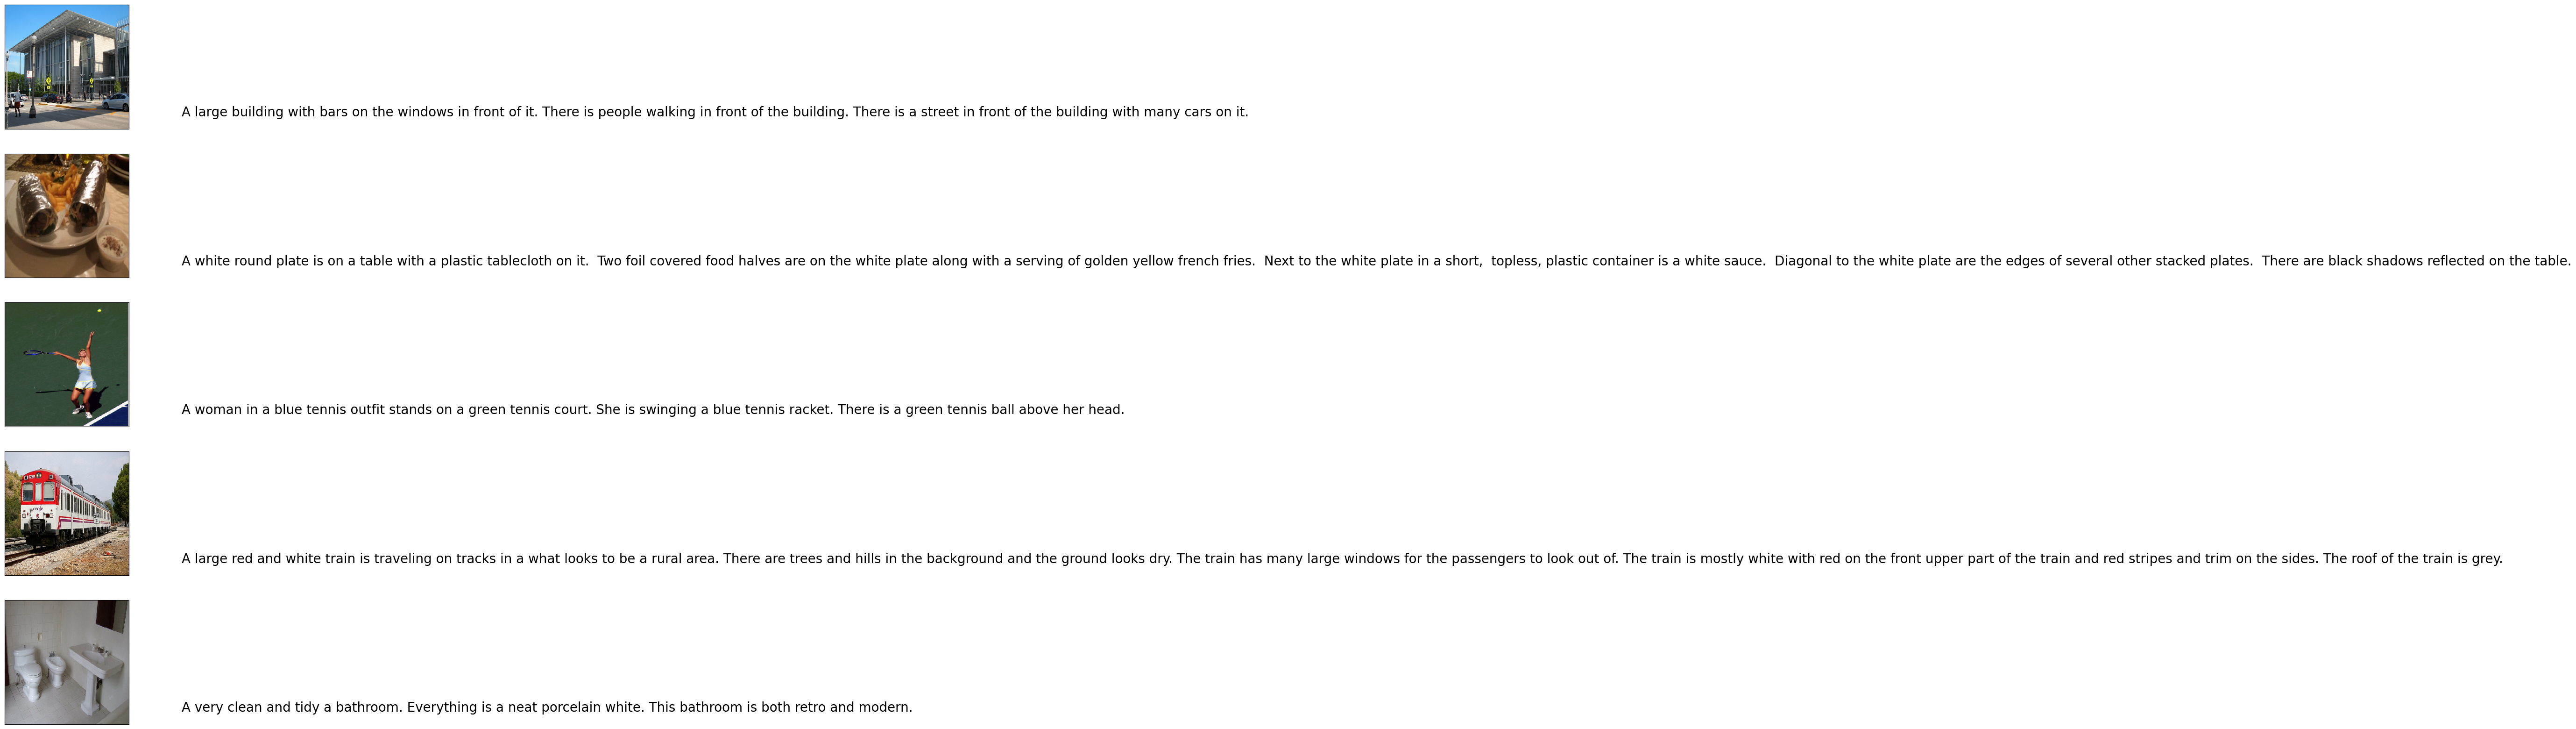

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize=(10,20))
npic =5
count=1
for i, img_path in enumerate(merged_df['image_path'][0:npic]):
    #plt.figure()
   # img = plt.imread(img)
    img= load_img(img_path, target_size=(299,299,3))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    ##plot the image subplot
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(img)
    count +=1
    ##plot the text subplot with corresponding para
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,30)
    ax.text(0, 3, merged_df['Paragraph'][i], fontsize=20)
    ax.axis('off')
    #for i, cap in enumerate(merged_df['Paragraph'][0:npic]):
      #ax.text(0,i,cap,fontsize=30)
    count +=1
plt.show()

Pre-process Image data

In [ ]:
df_img_train=merged_df.loc[merged_df['train']==True,['Image_name','image_path','train']]
df_img_test=merged_df.loc[merged_df['test']==True,['Image_name','image_path', 'test']]
df_img_test.head()

,Image_name,image_path,test
0,2356347,./data/stanford_img/content/stanford_images/23...,True
2,2414610,./data/stanford_img/content/stanford_images/24...,True
6,2388203,./data/stanford_img/content/stanford_images/23...,True
15,2396483,./data/stanford_img/content/stanford_images/23...,True
46,2316231,./data/stanford_img/content/stanford_images/23...,True


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception , preprocess_input
#from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

model = Xception(weights='imagenet' )
model= Model(model.input, model.layers[-2].output)
# summarize
print(model.summary())
#image_feature_layer = base_model.output
#image_feature_layer = keras.layers.GlobalAveragePooling2D()(image_feature_layer)
#image_feature_layer = keras.layers.Dense(2048, activation='relu')(image_feature_layer)
#image_feature_extractor = Model(inputs=base_model.input, outputs=image_feature_layer)

# Preprocess images for Xception model
#x = preprocess_input(images)

# Extract visual features
#visual_features = model.predict(x)


#base_model = Xception(weights='imagenet', include_top=False)
#image_feature_layer = base_model.output
#image_feature_layer = tf.keras.layers.GlobalAveragePooling2D()(image_feature_layer)
#image_feature_layer = tf.keras.layers.Dense(2048, activation='relu')(image_feature_layer)
#image_feature_extractor = Model(inputs=base_model.input, outputs=image_feature_layer)



91884032/91884032 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
# Extract visual features from the intermediate layer of the CNN model
def extract_features(image_paths, model):
    image_features = []
    for path in image_paths:
        img = load_img(path, target_size=(299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0) #(1, height, width, channels)
        img = preprocess_input(img)
        features = model.predict(img)
        image_features.append(features.flatten())
    return image_features

image_paths = df_img_train['image_path'].values
image_features = extract_features(image_paths, model)

# Save visual features and image identifiers
image_ids = df_img_train['Image_name'].values
with open('image_features.pkl', 'wb') as f:
    pickle.dump((image_ids, image_features), f)

# Extract visual features for test images
test_image_paths = df_img_test['image_path'].values
test_image_features = extract_features(test_image_paths, model)

# Save visual features and image identifiers for test images
test_image_ids = df_img_test['Image_name'].values
with open('test_image_features.pkl', 'wb') as f:
    pickle.dump((test_image_ids, test_image_features), f)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 390ms/step


In [ ]:
# store train features in pickle
#pickle.dump(train_image_features, open(os.path.join('drive/MyDrive/', 'features_train_img.pkl'), 'wb'))
import pickle
# store test features in pickle
#pickle.dump(test_image_features, open(os.path.join('drive/MyDrive/', 'features_test_img.pkl'), 'wb'))

with open('image_features.pkl', 'rb') as f:
  image_features = pickle.load(f)
image_features[1][14000]


array([0.00988936, 0.        , 0.2191974 , ..., 0.22878581, 0.21362694,
       0.01762927], dtype=float32)

#Preprocess Paragraph caption

In [ ]:
df_cap_train=merged_df.loc[merged_df['train']==True,['image_path', 'Paragraph']]
#df_cap_train['image_path'] = df_cap_train['Image_name'].apply(lambda x: image_dict.get(x, ''))
df_cap_train.head()
df_cap_test=merged_df.loc[merged_df['test']==True,['image_path', 'Paragraph']]
df_cap_val=merged_df.loc[merged_df['val']==True,['image_path', 'Paragraph', 'val']]
print("size of train, test and validation dataset:" ,len(df_cap_train),len(df_cap_test),len(df_cap_val))
# 14575 2489 2487


size of train, test and validation dataset: 14575 2489 2487


In [ ]:
#preprocess text
df_cap_train['Paragraph'] = df_cap_train['Paragraph'].apply(lambda x: preprocess_text(x))
df_cap_test['Paragraph'] = df_cap_test['Paragraph'].apply(lambda x: preprocess_text(x))

In [ ]:
df_cap_train.head()

,image_path,Paragraph
1,./data/stanford_img/content/stanford_images/23...,startseq white round plate is on table with pl...
3,./data/stanford_img/content/stanford_images/23...,startseq large red and white train is travelin...
4,./data/stanford_img/content/stanford_images/23...,startseq very clean and tidy bathroom. everyth...
5,./data/stanford_img/content/stanford_images/23...,startseq there are four small pizzas on brown ...
7,./data/stanford_img/content/stanford_images/23...,startseq black and white cat is sitting in whi...


In [ ]:
df_cap_test.head()

,image_path,Paragraph
0,./data/stanford_img/content/stanford_images/23...,startseq large building with bars on the windo...
2,./data/stanford_img/content/stanford_images/24...,startseq woman in blue tennis outfit stands on...
6,./data/stanford_img/content/stanford_images/23...,startseq the man is taking photo in the round ...
15,./data/stanford_img/content/stanford_images/23...,startseq people are on play ground standing in...
46,./data/stanford_img/content/stanford_images/23...,startseq person is skiing through the snow. th...


In [ ]:
#tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_cap_train['Paragraph'] )

train_seqs = tokenizer.texts_to_sequences(df_cap_train['Paragraph'] )
test_seqs = tokenizer.texts_to_sequences(df_cap_test['Paragraph'] )

train_cap_vector = pad_sequences(train_seqs, padding='post')
test_cap_vector = pad_sequences(test_seqs, padding='post')

Glove Embeddings & tokenize

In [ ]:
# Download the GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-06-18 13:26:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-18 13:26:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-18 13:26:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Convert words into GLoVE embeddings
def load_glove_embeddings(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    print("vocab_size:",vocab_size)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():  ### index to word ?
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Create vocabulary for training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_cap_train['Paragraph'].values)


embeddings_path = 'glove.6B.300d.txt'  # Path to the GLoVE embeddings file
embedding_dim = 300  # GLoVE embedding dimension

embeddings_index = load_glove_embeddings(embeddings_path)
embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, embedding_dim)

#vocab_size = len(tokenizer.word_index) + 1
#print(vocab_size)
# get maximum length of the caption available
max_len = max(len(caption.split()) for caption in df_cap_train['Paragraph'])
print("max_length:",max_len)



vocab_size: 10986
max_length: 252


In [ ]:
# Convert text to sequences
#train_sequences = tokenizer.texts_to_sequences(df_cap_train['Paragraph'].values)
#train_data = pad_sequences(train_sequences, maxlen=max_len, padding='post')

# Convert labels to one-hot vectors
#train_labels = to_categorical(train_sequences, num_classes=vocab_size)


In [ ]:
def data_generator(data, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for i, caption in enumerate(data):
            n += 1
            seq = tokenizer.texts_to_sequences([caption])[0]
            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(features[1][i])  # Use the corresponding image feature
                X2.append(in_seq)
                y.append(out_seq)

                if n == batch_size:
                    X1 = np.array(X1)
                    X2 = np.array(X2)
                    y = np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = [], [], []
                    n = 0


#Model Creation

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, TimeDistributed
import tensorflow as tf
import numpy as np

from keras.layers import Dropout
# Model architecture
import tensorflow as tf

# Model architecture
def create_model(vocab_size, max_len, embedding_dim, hidden_units, dropout_rate):
    # Image encoder
    input_img_features = tf.keras.Input(shape=(2048,))
    img_encoder = tf.keras.layers.Dropout(dropout_rate)(input_img_features)
    img_encoder = tf.keras.layers.Dense(embedding_dim, activation='relu')(img_encoder)
    # Reduce dimension of image encoder
    img_encoder = tf.keras.layers.Dense(hidden_units)(img_encoder)

    # Text encoder
    input_captions = tf.keras.Input(shape=(max_len,))
    text_embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(input_captions)
    text_encoder = tf.keras.layers.LSTM(hidden_units)(text_embeddings)

    # Attention mechanism (Additive Bahdanau)
    attention = tf.keras.layers.AdditiveAttention(use_scale=True)([text_encoder, img_encoder])
    context_vector = tf.keras.layers.Concatenate(axis=-1)([text_encoder, attention])

    # Decoder
    decoder = tf.keras.layers.Dense(hidden_units, activation='relu')(context_vector)
    output = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder)

    model = tf.keras.Model(inputs=[input_img_features, input_captions], outputs=output)
    return model


# Parameters
#image_size = 224
#vocab_size = len(tokenizer.word_index) + 1
#embedding_dim = 300
hidden_units = 256


In [ ]:
#from keras.optimizers import Adam

## Set the optimizer and compile the model
#optimizer = Adam(lr=0.001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)
# Create the model
dropout_rate= 0.5
vocab_size=10986
model = create_model(vocab_size, max_len, embedding_dim, hidden_units, dropout_rate)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 252)]        0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 252, 300)     3295800     ['input_3[0][0]']                
                                                                                            

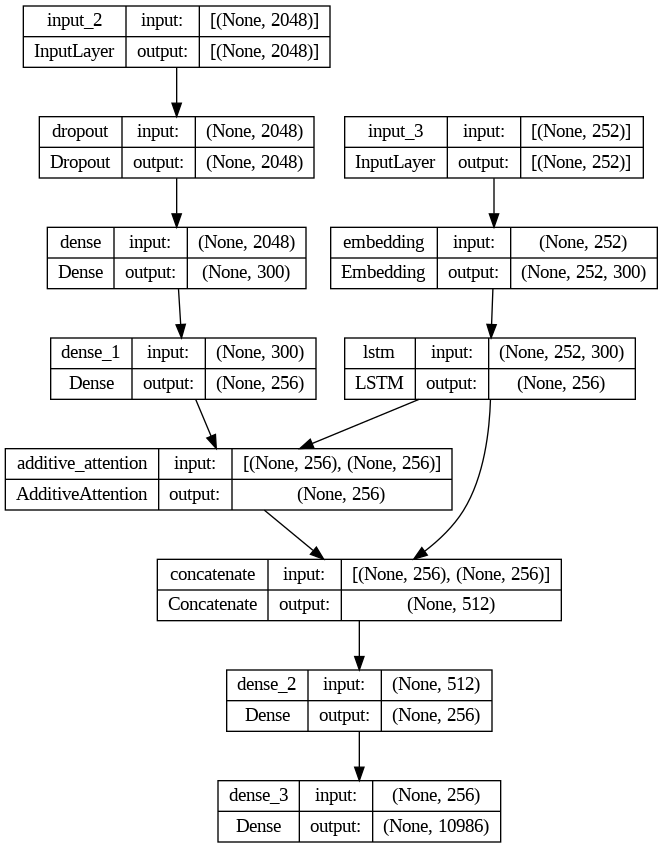

In [ ]:
 #plot the model
plot_model(model, show_shapes=True)

In [ ]:
# Set the embedding layer weights to the pre-trained GLoVE embeddings
model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False


In [ ]:
epochs = 10
batch_size = 16
steps = len(df_cap_train['Paragraph'])// batch_size
print("steps:", steps)

# Train the model
for i in range(epochs):
    generator = data_generator(df_cap_train['Paragraph'], image_features, tokenizer, max_len, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Save the trained model
model.save('model.h5')

steps: 910
910/910 [==============================] - 833s 915ms/step - loss: 2.4312 - accuracy: 0.4440


In [ ]:
epochs = 40
batch_size = 16
steps = len(df_cap_train['Paragraph'])// batch_size
print("steps:", steps)

# Train the model
for i in range(epochs):
    generator = data_generator(df_cap_train['Paragraph'], image_features, tokenizer, max_len, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Save the trained model
model.save('model1.h5')

steps: 910
  8/910 [..............................] - ETA: 3:11:10 - loss: 8.1647 - accuracy: 0.0880

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
# Load the best model
model = load_model('model.h5')


In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
with open('test_image_features.pkl', 'rb') as f:
  test_image_features = pickle.load(f)

In [ ]:
len(test_image_features[1])

2489

In [ ]:
#max_len_test = max(len(caption.split()) for caption in df_cap_test['Paragraph'])
#rint("max_length:",max_len_test)
vocab_size=10986

In [ ]:
def generate_captions(model, image_features, tokenizer, max_length):
    start = 'startseq'
    captions = [start]
    seq = tokenizer.texts_to_sequences(captions)[0]
    for _ in range(max_length):
        in_seq = pad_sequences([seq], maxlen=max_length)[0]
        in_seq = np.array(in_seq)
        yhat = model.predict([image_features[np.newaxis, :], in_seq[np.newaxis, :]], verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        word = word_for_id(yhat[0], tokenizer)
        captions[0] += ' ' + word
        seq.append(yhat[0])
        if word == 'endseq':
            break
    return captions[0].split()[1:-1]  # Exclude startseq and endseq



In [ ]:
# Generate captions for 5 samples using your model on the test data
num_samples = 5
test_captions = []
for i in range(num_samples):
    image_feature = test_image_features[1][i]
    caption = generate_captions(model, image_feature, tokenizer, max_len)
    test_captions.append(caption)

# Print the test captions
for i, caption in enumerate(test_captions):
    print(f"Sample {i+1} Caption: {caption}")


Sample 1 Caption: ['this', 'is', 'an', 'image', 'of', 'city', 'street', 'there', 'is', 'city', 'street', 'there', 'is', 'large', 'city', 'bus', 'on', 'the', 'street', 'there', 'is', 'large', 'city', 'bus', 'in', 'the', 'street', 'there', 'is', 'large', 'city', 'street', 'there', 'is', 'large', 'city', 'street', 'off', 'in', 'the', 'distance', 'there', 'is', 'large', 'tree', 'in', 'the', 'street', 'there', 'is', 'large', 'tree', 'in', 'the', 'street', 'there', 'is', 'large', 'tree', 'in', 'the', 'foreground', 'there', 'is', 'large', 'tree', 'in', 'the', 'foreground']
Sample 2 Caption: ['man', 'is', 'standing', 'on', 'the', 'beach', 'with', 'surfboard', 'the', 'man', 'is', 'wearing', 'wetsuit', 'the', 'wetsuit', 'is', 'white', 'and', 'has', 'white', 'surfboard', 'the', 'man', 'is', 'wearing', 'wetsuit', 'the', 'wetsuit', 'is', 'white', 'and', 'has', 'white', 'surfboard', 'the', 'man', 'is', 'wearing', 'black', 'wetsuit']
Sample 3 Caption: ['this', 'is', 'an', 'image', 'of', 'some', 'anim

In [ ]:
def generate_captions_beam_search(model, image_features, tokenizer, max_length, beam_index=3):
    start = 'startseq'
    captions = [{'caption': [start], 'probability': 1.0}]
    completed_captions = []
    for _ in range(max_length):
        candidates = []
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption['caption']])[0]
            in_seq = pad_sequences([seq], maxlen=max_length)[0]
            in_seq = np.array(in_seq)
            yhat = model.predict([image_features[np.newaxis, :], in_seq[np.newaxis, :]], verbose=0)
            yhat = np.argsort(yhat[0])[-beam_index:]  # Select top-k words based on probabilities
            for word in yhat:
                new_caption = caption['caption'] + [word]
                new_probability = caption['probability'] * yhat[word]
                candidates.append({'caption': new_caption, 'probability': new_probability})

        captions = sorted(candidates, key=lambda x: x['probability'], reverse=True)[:beam_index]  # Select top-k candidates
        completed_captions = [caption for caption in captions if caption['caption'][-1] == 'endseq']
        captions = [caption for caption in captions if caption['caption'][-1] != 'endseq']

        if len(completed_captions) == beam_index:
            break

    if len(completed_captions) > 0:
        captions = completed_captions

    return captions[0]['caption'][1:-1]  # Exclude startseq and endseq



In [ ]:
# Generate captions using beam search for 5 samples on the test data
num_samples = 5
beam_index = 3
test_captions_beam = []
for i in range(num_samples):
    image_feature = test_image_features[1][i]
    caption_beam = generate_captions_beam_search(model, image_feature, tokenizer, max_len, beam_index)
    test_captions_beam.append(caption_beam)

# Print the test captions generated using beam search
for i, caption in enumerate(test_captions_beam):
    print(f"Sample {i+1} Caption (Beam Search): {caption}")

IndexError: ignored

In [ ]:
import nltk

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

# Generate captions using your model on the test data
full_test_captions = []
for i in range(0,5):       #len(test_image_features[1]
    image_feature = test_image_features[1][i]
    caption = generate_captions(model, image_feature, tokenizer, max_len)
    full_test_captions.append(caption)
#test_captions = generate_captions(model, image_features, tokenizer, max_len)





In [ ]:
#full_test_captions

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
# Prepare reference captions and candidate captions
references = [[caption.split()] for caption in df_cap_test['Paragraph'][0:5]]  # Tokenize each reference caption
candidates = full_test_captions
# Calculate BLEU scores
bleu_1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))
#bleu_4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))
bleu_4 = corpus_bleu(references, candidates)

references = [[caption] for caption in df_cap_test['Paragraph'][0:5]]  # Tokenize each reference caption
#candidates = [word_tokenize(caption) for caption in full_test_captions]  # Tokenize each candidate caption
# Calculate METEOR score
meteor = meteor_score(references, candidates)

print("BLEU-1:", bleu_1)
print("BLEU-2:", bleu_2)
print("BLEU-3:", bleu_3)
print("BLEU-4:", bleu_4)
print("METEOR:", meteor)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


TypeError: ignored

In [ ]:
# Calculate METEOR score
refrences= '"hello" ," world"'
candidates= '"hello" ," world"'
meteor = meteor_score(references, candidates)
print("METEOR:", meteor)

TypeError: ignored

# Testing